<a href="https://colab.research.google.com/github/EnocPinto/Time-series-analysis-with-Python/blob/main/EDA_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Remove all variables
%reset

In [ ]:
#If error importing auto_arima, run this code first
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.4 MB/s 
     |████████████████████████████████| 9.9 MB 36.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [ ]:
#Libraries 

#General libraries
import pandas as pd
import numpy as np
from datetime import datetime

#Plotting libraries
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7]

#Statistical libraries
from statsmodels.tsa.api import VARMAX
from scipy.stats import pearsonr
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# **Table of contents**

1. Exploratory data analysis
    - 1.1 Load and plot data
    - 1.2 Augmented Dickey-Fuller Test (ADF Test) and differentiating
    - 1.3 Pearson correlation coefficient
    - 1.4 Granger-Causality test
    - 1.5 Johansen Cointegration Test

# **1. Exploratory data analysis**

## **1.1 Load and plot data**

In [ ]:
#Load data
DFF = pd.read_csv("DFF.csv", index_col = 0, parse_dates = True, na_values = ".", delimiter=',')
UNRATE = pd.read_csv("UNRATE.csv", index_col = 0, parse_dates = True, na_values = ".", delimiter=',')
CPIU_monthly = pd.read_csv("CPIU.csv", delimiter = ",")

#Calculate monthly average values for DFF
DFF_monthly = DFF.resample("M").apply(np.mean)

#Add month and year column for merge
DFF_monthly["Year"] = DFF_monthly.index.year
DFF_monthly["Month"] = DFF_monthly.index.month
UNRATE["Year"] = UNRATE.index.year
UNRATE["Month"] = UNRATE.index.month

#Create final dataframe
merge_df = DFF_monthly.merge(UNRATE, how = 'inner', on = ['Year', 'Month'])
final_df = merge_df.merge(CPIU_monthly, how = 'inner', on = ['Year', 'Month'])

#Prepare final DataFrame with all variables for analysis
final_df["DATE"] = pd.to_datetime(final_df[["Year", "Month"]].assign(DAY=1))
final_df = final_df.set_index("DATE")
final_df = final_df.drop(columns=["Month", "Year"])
final_df = final_df.round(2)
final_df

,DFF,UNRATE,CPIU
DATE,,,
1958-01-01,2.72,5.8,3.62
1958-02-01,1.67,6.4,3.25
1958-03-01,1.20,6.7,3.60
1958-04-01,1.26,7.4,3.58
1958-05-01,0.63,7.4,3.21
...,...,...,...
2022-02-01,0.08,3.8,7.87
2022-03-01,0.20,3.6,8.54
2022-04-01,0.33,3.6,8.26


In [ ]:
#Summary statistics, rounding to two decimal places.
final_df.describe().applymap('{:,.2f}'.format)

,DFF,UNRATE,CPIU
count,774.00,774.00,774.00
mean,4.73,5.98,3.68
std,3.68,1.66,2.82
min,0.05,3.40,-2.10
25%,1.77,4.83,1.73
50%,4.59,5.70,2.94
75%,6.54,7.00,4.60
max,19.10,14.70,14.76


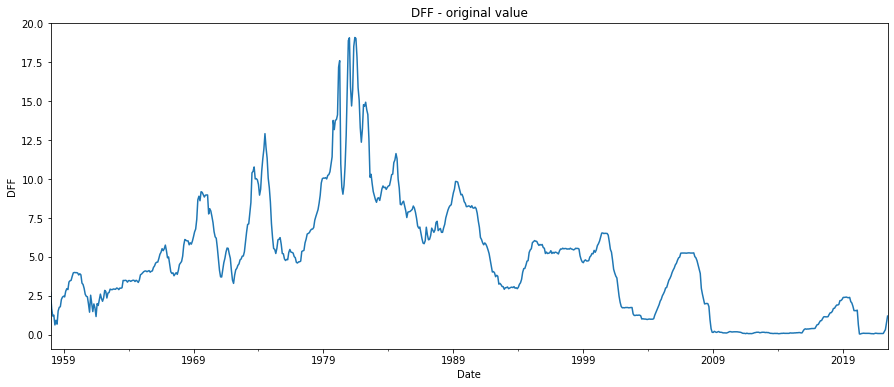

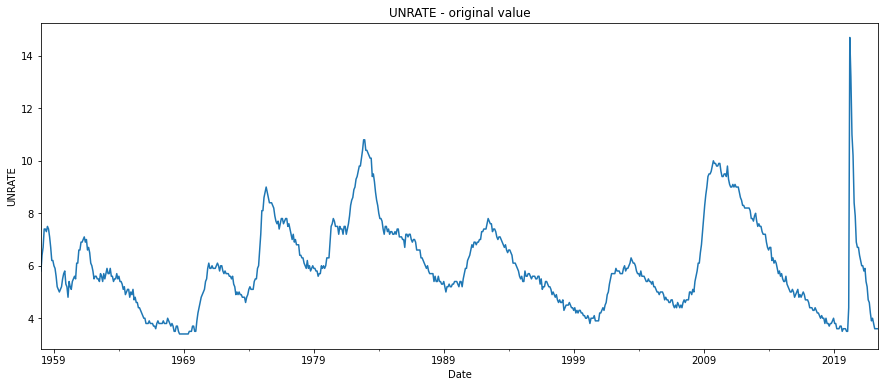

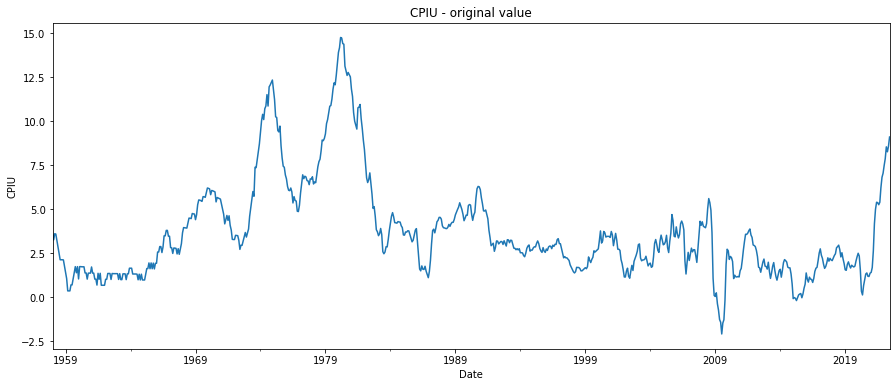

In [ ]:
#Plot original variables
for c in final_df[["DFF", "UNRATE", "CPIU"]]:
    final_df[str(c)].plot(figsize=(15, 6))
    plt.xlabel("Date")
    plt.ylabel(c)
    plt.title(f"{str(c)} - original value")
    plt.show()

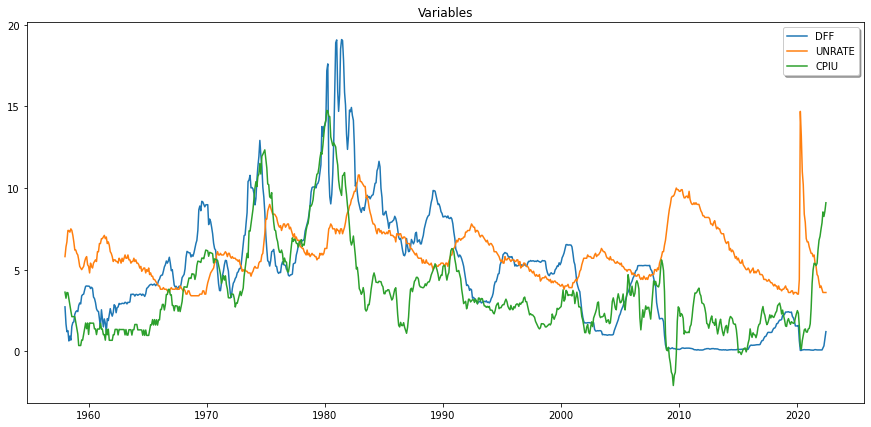

In [ ]:
#Plot all variables together
plt.plot("DFF", data = final_df)
plt.plot("UNRATE", data = final_df)
plt.plot("CPIU", data = final_df)
plt.legend(("DFF", "UNRATE", "CPIU"), loc = "upper right", shadow = True)
plt.title("Variables")
plt.show()

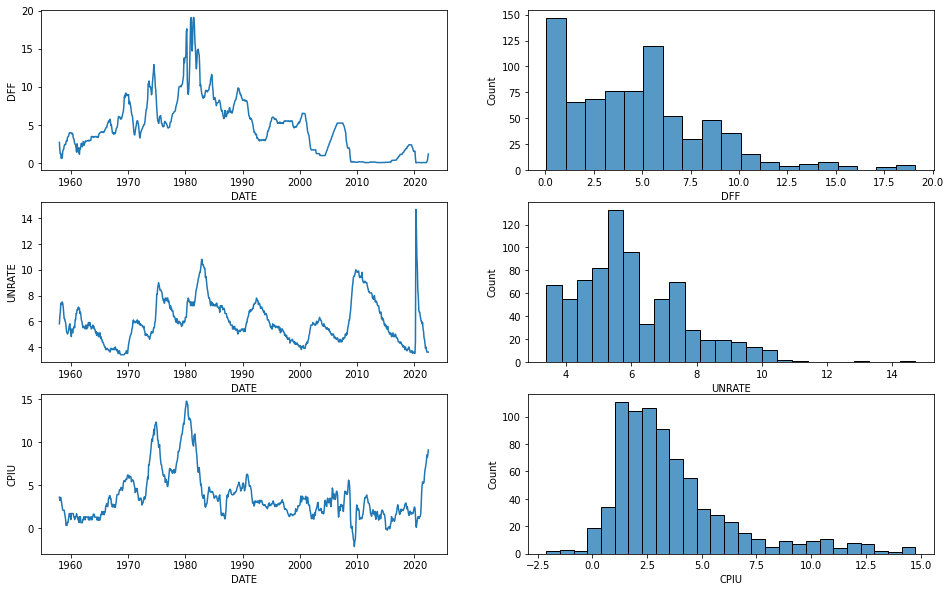

In [ ]:
#Plot line and histogram plots for each variable
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(16, 10))
sns.lineplot(data=final_df.DFF, ax=axs[0,0])
sns.histplot(data=final_df.DFF, ax=axs[0,1])
sns.lineplot(data=final_df.UNRATE, ax=axs[1,0])
sns.histplot(data=final_df.UNRATE, ax=axs[1,1])
sns.lineplot(data=final_df.CPIU, ax=axs[2,0])
sns.histplot(data=final_df.CPIU, ax=axs[2,1])

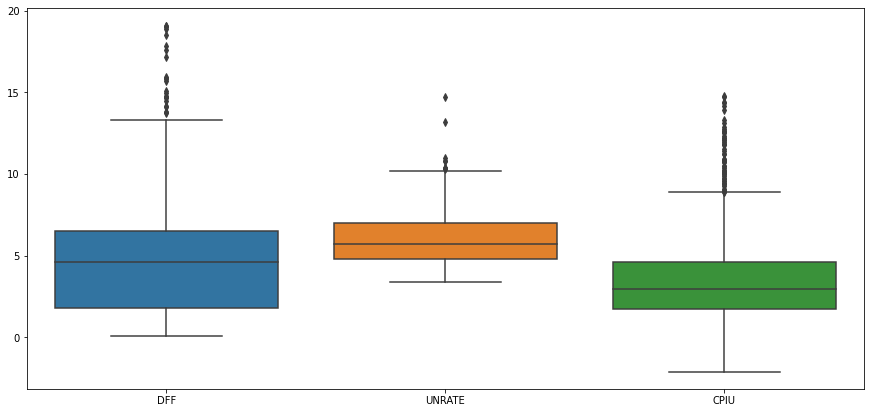

In [ ]:
#Boxplot of each variable
sns.boxplot(data=final_df)

## **1.2 Augmented Dickey Fuller Test (ADF Test) and differentiating**

**Definition:**

The ADF test belongs to a category of tests called "Unit Root Test", and it's used for testing the stationarity of a time series. The unit root is a characteristic of a time series that makes it non-stationary. A unit root exists in a time series of the value of alpha = 1 in the below equation.
Where Yt is the value of the time series at time "t" and Xe is an exogenous variable (a separate explanatory variable, which is also a time series).
The presence of a unit root means the time series is non-stationary. The number of unit roots in the series will give us the number of differencing operations required to make the series stationary.

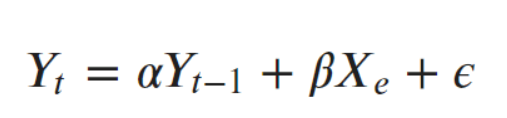

**Interpretation:**

- **H0 (Null hypothesis):** The time series has a unit root, i.e., the series is not stationary.
- **H1 (Alternative hypothesis):** The time series does not have a unit root, i.e., the series is stationary.

Since the p-value of the original DFF series is greater than the significant level of 0.05, we cannot reject the null hypothesis and conclude there is insufficient evidence that DFF is stationary. After applying the first-order difference to the original values of DFF, the test results return a p-value lower than 0.05, which means that we can reject the null hypnotises and confirm that the differenced DFF series is stationary, hence the value of d will be equal to 1.

In [ ]:
#Check if the data is stationary using the Augmented Dickey-Fuller test for CPIU and UNRATE even though we reject #the null hypothesis, 
#we can observe that both time series have a trend

Stationary_test = adfuller(final_df["CPIU"]) 
print(f"Test statistic: {Stationary_test[0]}")
print(f"p-value: {Stationary_test[1]}")

if Stationary_test[1] > 0.05:
    print("TS CPIU is not stationary")
else:
    print("TS CPIU is stationary")

print(" ----- ")

Stationary_test = adfuller(final_df["UNRATE"]) 
print(f"Test statistic: {Stationary_test[0]}")
print(f"p-value: {Stationary_test[1]}")

if Stationary_test[1] > 0.05:
    print("TS UNRATED is not stationary")
else:
    print("TS UNRATED is stationary")

Test statistic: -3.0774644712920227
p-value: 0.028266495394058153
TS CPIU is stationary
 ----- 
Test statistic: -3.5243721230409415
p-value: 0.007382788796378324
TS UNRATED is stationary


In [ ]:
#Apply 1st order difference although Adfuller returns a p-value less than 0.05
final_df["DFF_diff"] = final_df.DFF.diff(1) 
final_df["UNRATE_diff"] = final_df.UNRATE.diff(1) 
final_df["CPIU_diff"] = final_df.CPIU.diff(1) 
final_df.dropna(inplace=True)
final_df

,DFF,UNRATE,CPIU,DFF_diff,UNRATE_diff,CPIU_diff
DATE,,,,,,
1958-02-01,1.67,6.4,3.25,-1.05,0.6,-0.37
1958-03-01,1.20,6.7,3.60,-0.47,0.3,0.35
1958-04-01,1.26,7.4,3.58,0.06,0.7,-0.02
1958-05-01,0.63,7.4,3.21,-0.63,0.0,-0.37
1958-06-01,0.93,7.3,2.85,0.30,-0.1,-0.36
...,...,...,...,...,...,...
2022-02-01,0.08,3.8,7.87,0.00,-0.2,0.39
2022-03-01,0.20,3.6,8.54,0.12,-0.2,0.67
2022-04-01,0.33,3.6,8.26,0.13,0.0,-0.28


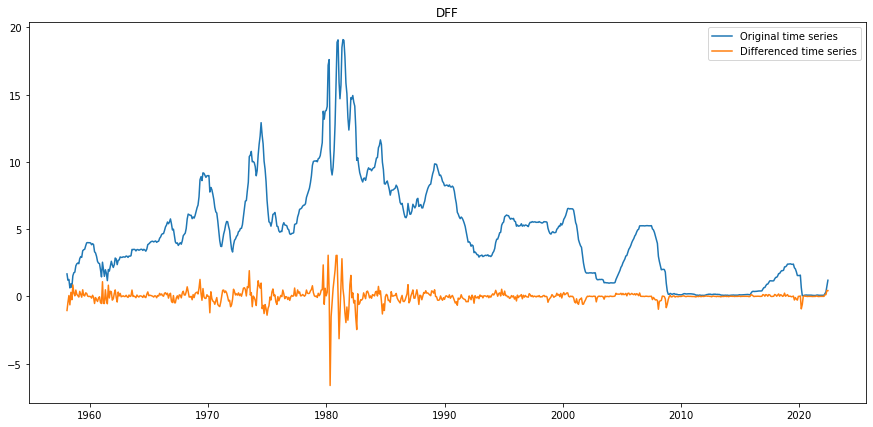

In [ ]:
#Plot DFF original and differenced series 
plt.plot(final_df.DFF, label="Original time series")
plt.plot(final_df.DFF_diff, label="Differenced time series")
plt.title("DFF")
plt.legend()

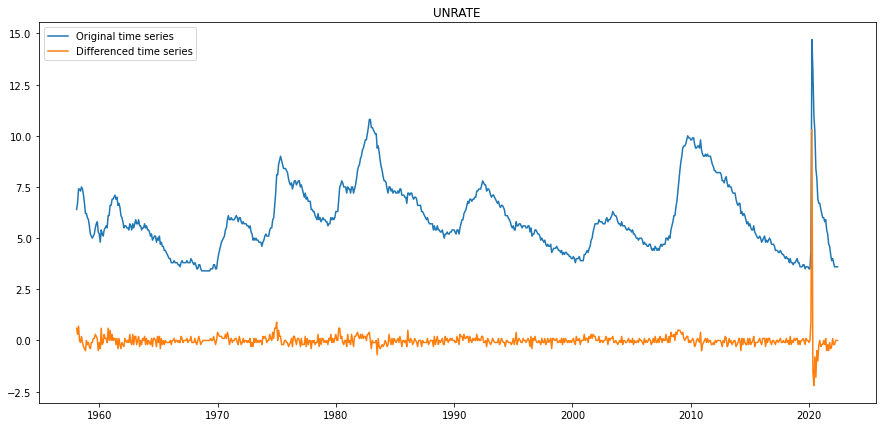

In [ ]:
#Plot UNRATE original and differenced series 
plt.plot(final_df.UNRATE, label="Original time series")
plt.plot(final_df.UNRATE_diff, label="Differenced time series")
plt.title("UNRATE")
plt.legend()

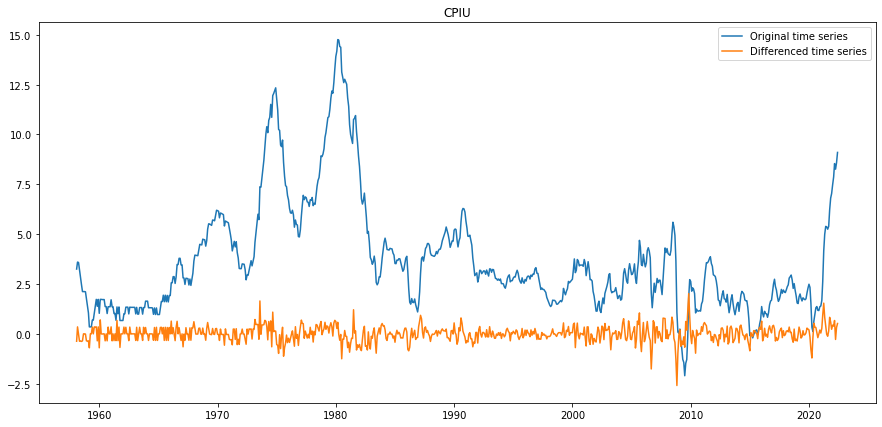

In [ ]:
#Plot CPIU original and differenced series 
plt.plot(final_df.CPIU, label="Original time series")
plt.plot(final_df.CPIU_diff, label="Differenced time series")
plt.title("CPIU")
plt.legend()

In [ ]:
#Run again the Augmented Dickey–Fuller test for CPIU and UNRATE

Stationary_test = adfuller(final_df["UNRATE_diff"]) 
print(f"Test statistic: {Stationary_test[0]}")
print(f"p-value: {Stationary_test[1]}")

if Stationary_test[1] > 0.05:
    print("TS CPIU is not stationary")
else:
    print("TS CPIU is stationary")

print(" ----- ")

Stationary_test = adfuller(final_df["CPIU_diff"]) 
print(f"Test statistic: {Stationary_test[0]}")
print(f"p-value: {Stationary_test[1]}")

if Stationary_test[1] > 0.05:
    print("TS UNRATED is not stationary")
else:
    print("TS UNRATED is stationary")

Test statistic: -20.515191790268336
p-value: 0.0
TS CPIU is stationary
 ----- 
Test statistic: -5.607543760606389
p-value: 1.224437519614562e-06
TS UNRATED is stationary


## **1.3 Pearson correlation coefficient**

The Pearson Correlation Coefficient between two variables measures the strength of the linear relationship between them, and it was developed by the English mathematicians Karl Pearson in the 1880s. Its value ranges between -1 (perfect negative correlation) and 1 (perfect positive correlation). It is considered a helpful tool to analyse data as it gives a measure of the relation two variables have, although it has several limitations. The main limitation is that the variables might have a different type of relationship other than linear that the coefficient will not be able to capture. It can only be applied pairwise; it cannot analyse the relationship between three or more variables. The Pearson Correlation Coefficient is calculated by dividing the covariance of the two variables by the product of the standard deviation of each variable.

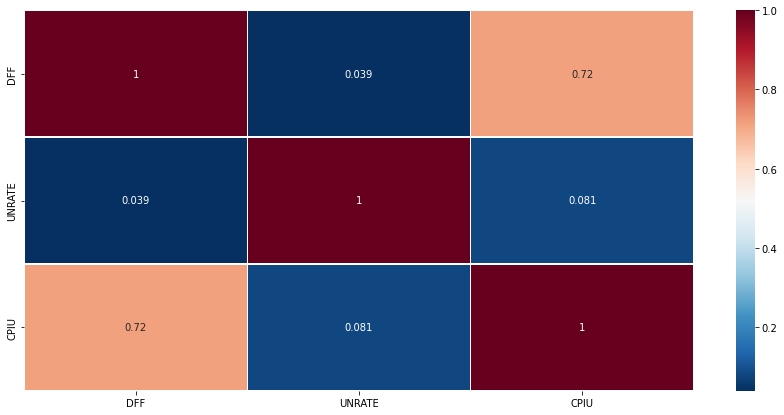

In [ ]:
#Plot the Pearson correlation coefficient between the three variables
pearsoncorr = final_df[["DFF",	"UNRATE",	"CPIU"]].corr(method="pearson")
sns.heatmap(pearsoncorr, xticklabels=pearsoncorr.columns, yticklabels=pearsoncorr.columns, cmap="RdBu_r", annot=True, linewidth=0.5)
plt.show()

## **1.4 Granger-Causality test**

The concept of causality approaches the analysis of the relationship between variables from a different perspective. Causality can be understood as the influence by which one event, process, or object contributes to the creation of another event, process, or object. Clive W.J. Granger developed the Granger Causality test[3] that defines the causality between a variable X and a variable Y as the probability of correctly forecasting Yt…n will increase by adding information about the variable X. The limitation of this test comes from the fact that the causality defined by William John Granger is necessarily true causality, as if a third variable drives both X and Y, one might still fail to reject the null hypothesis. Additionally, the test can only be performed pairwise, and it is impossible to include more than two variables.

- **H0 (Null hypothesis for UNRATE):** UNRATE does not Granger-cause DFF.
- **H1 (Alternative hypothesis for UNRATE):** UNRATE does Granger-cause DFF
- **H0 (Null hypothesis for CPIU):** CPIU does not Granger-cause DFF.
- **H1 (Alternative hypothesis for CPIU):** CPIU does Granger-cause DFF

The results of the Granger Causality test are in line with those of the Pearson Correlation Coefficient. We can only reject the null hypothesis for CPIU/DFF at lag 7. At the same time, for UNRATE, the p-value is slight over the critical value of 0.05, indicating that we cannot reject the null hypothesis for a minimal margin.

In [ ]:
#Perform Granger-Causality test DFF vs UNRATE
grangercausalitytests(final_df[["DFF_diff", "UNRATE_diff"]], maxlag=12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4079  , p=0.0653  , df_denom=769, df_num=1
ssr based chi2 test:   chi2=3.4212  , p=0.0644  , df=1
likelihood ratio test: chi2=3.4136  , p=0.0647  , df=1
parameter F test:         F=3.4079  , p=0.0653  , df_denom=769, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.4436  , p=0.0875  , df_denom=766, df_num=2
ssr based chi2 test:   chi2=4.9191  , p=0.0855  , df=2
likelihood ratio test: chi2=4.9034  , p=0.0861  , df=2
parameter F test:         F=2.4436  , p=0.0875  , df_denom=766, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3714  , p=0.0692  , df_denom=763, df_num=3
ssr based chi2 test:   chi2=7.1795  , p=0.0664  , df=3
likelihood ratio test: chi2=7.1463  , p=0.0674  , df=3
parameter F test:         F=2.3714  , p=0.0692  , df_denom=763, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.1313  , p=0.0752  

{1: ({'ssr_ftest': (3.407871652821784, 0.06527023922311846, 769.0, 1),
   'ssr_chi2test': (3.4211663406741444, 0.06436552332756594, 1),
   'lrtest': (3.413608105876392, 0.06466092137384305, 1),
   'params_ftest': (3.407871652821798, 0.06527023922311846, 769.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (2.443575502921406, 0.08752652561390954, 766.0, 2),
   'ssr_chi2test': (4.919051469327425, 0.08547547941293118, 2),
   'lrtest': (4.90342589368106, 0.08614589670151716, 2),
   'params_ftest': (2.4435755029215, 0.08752652561390818, 766.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.3714198859264197, 0.06920868823077211, 763.0, 3),
   'ssr_chi2test': (7.179528095006592, 0.0663904888624678, 3),
   'lrtest': (7.146263524889946, 0.06737912560383404, 3),
   'params_ftest': (2.3714198859264397, 0.06920868823076606, 763.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0

In [ ]:
#Perform Granger-Causality test DFF vs UNRATE
grangercausalitytests(final_df[["DFF_diff", "CPIU_diff"]], maxlag=12)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3813  , p=0.2402  , df_denom=769, df_num=1
ssr based chi2 test:   chi2=1.3867  , p=0.2390  , df=1
likelihood ratio test: chi2=1.3855  , p=0.2392  , df=1
parameter F test:         F=1.3813  , p=0.2402  , df_denom=769, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0118  , p=0.1344  , df_denom=766, df_num=2
ssr based chi2 test:   chi2=4.0500  , p=0.1320  , df=2
likelihood ratio test: chi2=4.0394  , p=0.1327  , df=2
parameter F test:         F=2.0118  , p=0.1344  , df_denom=766, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4204  , p=0.2355  , df_denom=763, df_num=3
ssr based chi2 test:   chi2=4.3004  , p=0.2308  , df=3
likelihood ratio test: chi2=4.2884  , p=0.2320  , df=3
parameter F test:         F=1.4204  , p=0.2355  , df_denom=763, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5262  , p=0.1926  

{1: ({'ssr_ftest': (1.3813145752279257, 0.24024111543108115, 769.0, 1),
   'ssr_chi2test': (1.3867033186943543, 0.23896262001644689, 1),
   'lrtest': (1.3854593766825474, 0.23917340134102846, 1),
   'params_ftest': (1.3813145752278977, 0.24024111543113413, 769.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (2.011846824754079, 0.13444752866291299, 766.0, 2),
   'ssr_chi2test': (4.049957968369178, 0.13199661717522274, 2),
   'lrtest': (4.039358133080896, 0.13269804548983197, 2),
   'params_ftest': (2.011846824754225, 0.13444752866288928, 766.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.4204270048228556, 0.23548661809231639, 763.0, 3),
   'ssr_chi2test': (4.300375335702223, 0.2308025822686671, 3),
   'lrtest': (4.28841127083183, 0.23195796104869879, 3),
   'params_ftest': (1.4204270048229324, 0.2354866180923062, 763.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0

## **1.5 Johansen Cointegration Test**

The Johansen test analyses the relation between multiple time series from a different perspective compared to the Pearson Correlation Coefficient and the Granger Causality test. The Johansen test explores the concept of cointegration of non-stationary time series introduced by Granger and Engle in 1987 in the paper “Co-integration and error correction: representation, estimation, and testing”. They established that two or more non-stationary time series are integrated if, in the long term, they cannot move from an equilibrium point. One of the advantages of using Johansen´s test is that it can be used for testing cointegration between several time series simultaneously. On the other hand, test temps produce incorrect results when applied to small sample sizes, which might limit their use in some situations. The test has two statistics Maximum statistic and Eigenvalue statistic. In this test the null and alternative hypothesis are as follows:
- **H0 (Null hypothesis):** rank = 0, meaning there is no cointegration
- **H1 (Alternative hypothesis):** rank > 0 cointegration relationship between two or more time series.

The first test, rank = 0, checks the presence of cointegration among the time series. The trace statistic exceeds the critical value (50.75 > 29.79) at a 95% confidence interval, and therefore we can reject the null hypothesis and confirm the presence of cointegration. The second test for rank ≤ 1 against the alternative hypothesis of rank > 1 also provides clear evidence that the null hypothesis can be rejected at a 95% confidence interval (22.78 > 15.49). Lastly, the final test for rank ≤ 2 against the alternative hypothesis of rank > 2 also provides sufficient evidence to reject the null hypothesis and confirm that the rank of the matrix r is greater than 2. The output of the three tests confirms the presence of cointegration among the three time series.

In [ ]:
#Johansen test
test_result = coint_johansen(final_df[["DFF",	"CPIU", "UNRATE"]],0,1)

#Get trace statistics and confidence intervals critical values
trace_crit_vals = pd.DataFrame(test_result.trace_stat_crit_vals)
col_names = ["C 90%", "C 95%", "C 99%"]
trace_crit_vals.columns = col_names

trace_stat = test_result.trace_stat
trace_crit_vals.insert(0, "Trace Stat", trace_stat)

max_rank = ["Rank 0", "Rank 1", "Rank 2"]
trace_crit_vals.insert(0, "Maximun Rank", max_rank)

trace_crit_vals

,Maximun Rank,Trace Stat,C 90%,C 95%,C 99%
0,Rank 0,50.756091,27.0669,29.7961,35.4628
1,Rank 1,22.789010,13.4294,15.4943,19.9349
2,Rank 2,7.452450,2.7055,3.8415,6.6349


In [ ]:
#Get the Max eigenvalues and confidence intervals critical values
eig_stat_crit_vals = pd.DataFrame(test_result.max_eig_stat_crit_vals)
col_names = ["C 90%", "C 95%", "C 99%"]
eig_stat_crit_vals.columns = col_names

Max_Eig_stat = test_result.max_eig_stat
eig_stat_crit_vals.insert(0, "Max_Eig_stat", trace_stat)

max_rank = ["Rank 0", "Rank 1", "Rank 2"]
eig_stat_crit_vals.insert(0, "Maximun Rank", max_rank)

eig_stat_crit_vals

,Maximun Rank,Max_Eig_stat,C 90%,C 95%,C 99%
0,Rank 0,50.756091,18.8928,21.1314,25.8650
1,Rank 1,22.789010,12.2971,14.2639,18.5200
2,Rank 2,7.452450,2.7055,3.8415,6.6349
